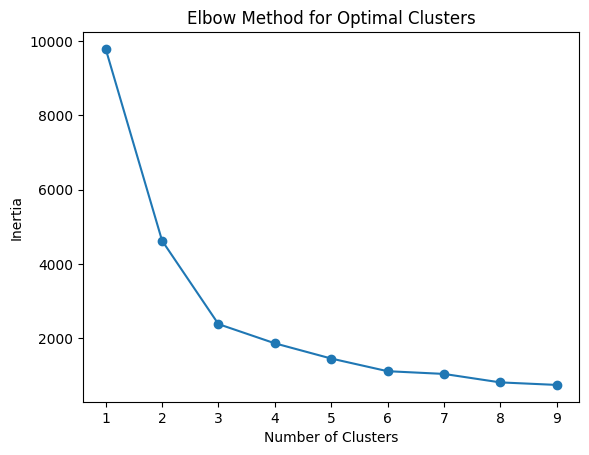

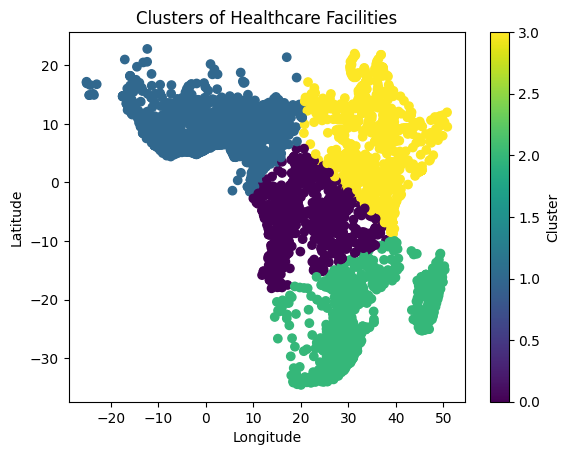

Regression Model R^2 Score: 1.00
Predicted Demand Scores for Sample Facilities: [ 8.  8. 22. 51. 19.]


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

file_path = '/content/healthcare-connectivity-dataset.csv'
data = pd.read_csv(file_path)

data = data.dropna(subset=['Latitude', 'Longitude'])

data['Facility_Owner_Encoded'] = data['Facility_Owner'].astype('category').cat.codes
data['Facility_Type_Encoded'] = data['Renamed_Facility_Type'].astype('category').cat.codes

scaler = StandardScaler()
data[['Latitude_Scaled', 'Longitude_Scaled']] = scaler.fit_transform(data[['Latitude', 'Longitude']])

coordinates = data[['Latitude_Scaled', 'Longitude_Scaled']]

inertia = []
for n in range(1, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(coordinates)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(coordinates)

plt.scatter(data['Longitude'], data['Latitude'], c=data['Cluster'], cmap='viridis')
plt.title('Clusters of Healthcare Facilities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

data['Demand_Score'] = (
    data['Cluster'] +
    data['Facility_Type_Encoded'] * 2 +
    data['Facility_Owner_Encoded']
)

features = ['Latitude_Scaled', 'Longitude_Scaled', 'Facility_Type_Encoded', 'Facility_Owner_Encoded', 'Cluster']
target = 'Demand_Score'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

score = regressor.score(X_test, y_test)
print(f"Regression Model R^2 Score: {score:.2f}")

joblib.dump(regressor, 'healthcare_connectivity_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

predicted_demand = regressor.predict(X_test[:5])
print("Predicted Demand Scores for Sample Facilities:", predicted_demand)
